# Plasma Communication Overhead Investigation

In this notebook we investigate the overhead of writing tensors to plasma and reading it, comparing it to just sending the image to zmq. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [2]:
import glob

In [8]:
files = glob.glob("../results/*.txt")

In [9]:
arrs = {
    path.split('/')[2].split('.')[0]: np.loadtxt(path) for path in files
}
arrs

{'plasma-noop': array([1399.,  736.,  730., ...,  713.,  708.,  725.]),
 'plasma-read': array([1422.,  789.,  766., ...,  721.,  783.,  716.]),
 'zmq-noop': array([1800., 1606., 1282., ...,  709.,  688.,  720.]),
 'zmq-read': array([1074.,  905.,  909., ...,  672.,  690.,  687.])}

In [17]:
arrs['plasma-read'].mean() - arrs['zmq-read'].mean()

32.501499999999965

In [25]:
np.median(arrs['plasma-read']) - np.median(arrs['zmq-read'])

35.0

In [18]:
arrs['plasma-read'].mean() - arrs['plasma-noop'].mean()

-1.4565000000000055

(0, 2000)

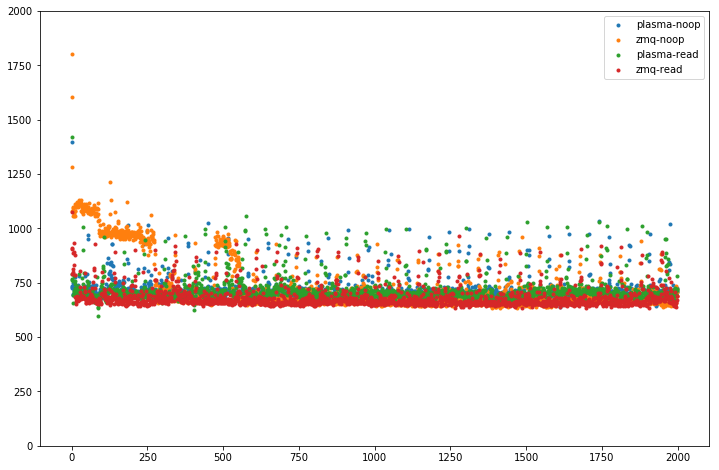

In [11]:
plt.figure(figsize=(12,8))
for name, arr in arrs.items():
#     if 'noop' not in name:
    plt.scatter(np.arange(2000), arr, label=name, marker='.')
plt.legend()
plt.ylim(0, 2000)

Text(0.5,1,'Distribution of durations (500 - 1500 us)')

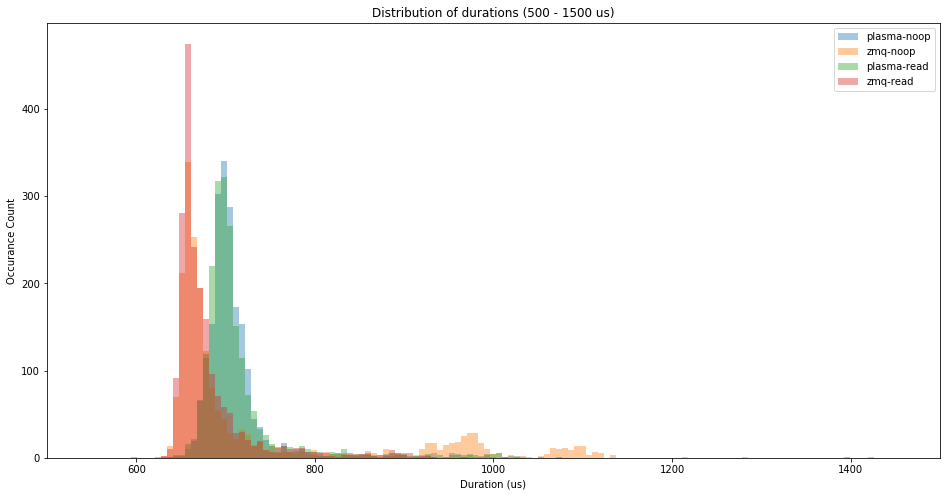

In [16]:
plt.figure(figsize=(16,8))
for name in arrs.keys():
    sns.distplot(arrs[name], bins=np.linspace(500, 1500, num=150), label=name, kde=False)
plt.xlim(500, 1500)
plt.legend()
plt.ylabel("Occurance Count")
plt.xlabel("Duration (us)")
plt.title("Distribution of durations (500 - 1500 us)")

## Fine-grained Plasma Performance Investigation

In [19]:
ts = pd.read_csv('../results/plasma-read.csv', header=None).drop(7, axis=1)

In [20]:
ts = pd.concat([pd.Series(np.zeros(2000).astype(int), name='start'), ts], axis=1)

In [21]:
ts_durations = ts.diff(axis=1).drop('start',axis=1)

In [22]:
timestamp = \
[
  'create_tensor', 'get_metadata', 'create_plasma_obj',
  'write_tensor', 'seal_plasma_obj','send_obj', 'recv_ack'
]

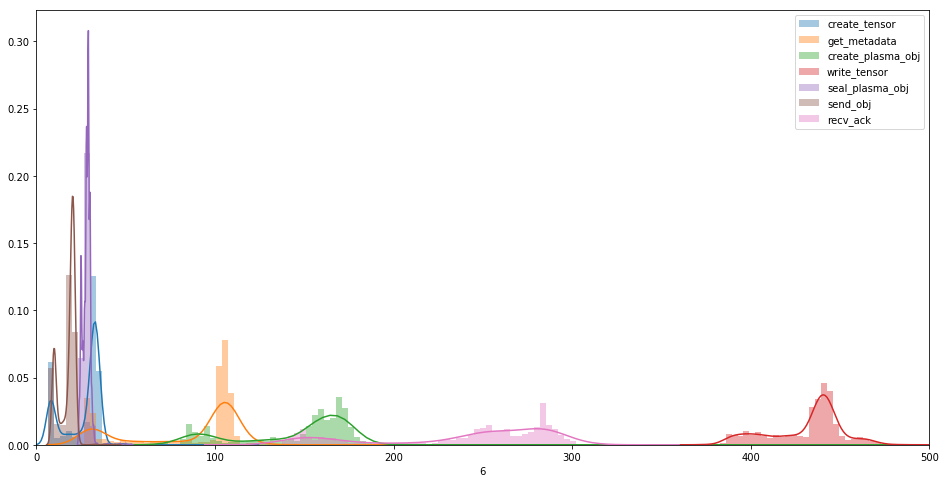

In [24]:
plt.figure(figsize=(16,8))

for name, col in zip(timestamp, ts_durations.columns):
    sns.distplot(ts_durations[col], bins=np.linspace(0,500,num=150), label=name)
plt.xlim(0, 500)
plt.legend()

In [32]:
ts_durations.iloc[:, :-2].sum(axis=1).mean()

715.172